# Import modules

In [1]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import qiskit
import pylatexenc
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import gym
from functools import reduce
from collections import deque, defaultdict

In [4]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math, random, time, itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter, ParameterVector
from tqdm.notebook import tqdm
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, CircuitOp, AerPauliExpectation, Zero, One, ListOp, PauliSumOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.utils import QuantumInstance, algorithm_globals

In [5]:
from Curling_win_flag import Curling
from ansatz import build_circuit

# Build CIrucit

### Ansatz list
- 'base'
- 'hw_eff'
- 'universal'
- 'universal_encoding'

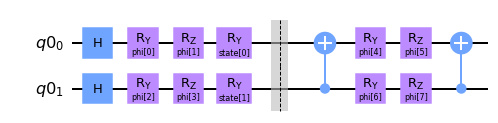

In [6]:
def draw_example():
    quantum_circuit, param_rot, param_enc = build_circuit(n_qubits=2, n_layers=1, opt='omega2')
    return quantum_circuit
draw_example().draw('mpl')

In [7]:
# circuit, rot_params, enc_params = build_circuit(n_qubits=2, n_layers=1)

In [8]:
class PQC_with_DataReuploading(nn.Module):
    def __init__(self, n_qubits, n_layers, output_dim, observables=None, ansatz='base', activation='linear'):
        super().__init__()
        
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.activation = activation
        self.ansatz = ansatz
        
        if observables == None:
            self.observables = Z^n_qubits
        else:
            self.observables = observables
        
        # Build circuits / Parameter Vectors
        self.circuit, self.rot_params, self.enc_params = build_circuit(self.n_qubits, self.n_layers, ansatz)
        self.len_rot_params = len(self.rot_params)
        self.len_enc_params = len(self.enc_params)
        
        self.psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
        self.Op = ~StateFn(self.observables) @ self.psi
#         print(self.Op)
        # set method to calculcate expected values
        expval = AerPauliExpectation()
        # define gradient method
        gradient = Gradient(grad_method='param_shift')
        # define quantum instances (statevector and sample based)
        qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
        # we set shots to 10 as this will determine the number of samples later on.
        qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1000)
        
        self.qnn = OpflowQNN(operator=self.Op, input_params=self.enc_params, weight_params=self.rot_params, 
                             exp_val=expval, gradient=gradient, quantum_instance=qi_sv, input_gradients=True)
        
        self.total_params = []
        for p in self.rot_params:
            self.total_params.append(p)
        for p in self.enc_params:
            self.total_params.append(p)
        
        # Initial Parameters for circuit
        self.rot_param_vals = nn.Parameter(2*np.pi * torch.rand(len(self.rot_params)))
#         self.rot_param_vals = nn.Parameter(2*np.pi * torch.zeros(len(self.rot_params)))
#         self.rot_param_vals = nn.Parameter(torch.tensor([-np.pi/2+0.1*np.random.rand(), -np.pi+0.1*np.random.rand(),
#                                                          -np.pi/2+0.1*np.random.rand(), -np.pi+0.1*np.random.rand()]))
#         self.enc_param_vals = nn.Parameter(torch.zeros(len(self.enc_params)))
        self.enc_param_vals  = nn.Parameter(torch.rand(len(self.enc_params)))
#         self.enc_param_vals  = nn.Parameter(torch.tensor([np.pi/2+0.1*np.random.rand(), -np.pi/2+0.1*np.random.rand()]))
        
        # Parameter for circuit output
#         self.w = nn.Parameter(nn.Parameter(torch.rand(self.output_dim)))
#         self.w = nn.Parameter(torch.tensor([-1,1], dtype=torch.float32))
        
    def forward(self, inputs):
        input_tiled = self.get_input_tiled(inputs)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
    
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        
#         action_exp = torch.tensor(expectation) * self.w
#         action_prob = F.softmax(action_exp, dim=1)
        
#         return action_prob
        return expectation

    def backward(self, inputs):
        input_tiled = self.get_input_tiled(inputs)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        enc_grad, rot_grad = self.qnn.backward(input_params.detach(), self.rot_param_vals.detach())
#         w_grad = torch.tensor(expectation).tile(self.output_dim)
#         return torch.tensor(rot_grad.squeeze()), torch.tensor(enc_grad.squeeze()), w_grad
        return torch.tensor(rot_grad.squeeze()), torch.tensor(enc_grad.squeeze())
    
    def get_input_tiled(self, inputs):
        # Input: State values -> Need to insert into Encoding gates with scaling parameters(encoding params)
        if self.ansatz == 'universal_encoding' or self.ansatz == 'hw_eff':
            input_tiled = inputs.tile(2)
            input_tiled = input_tiled.tile(self.n_layers)
        elif self.ansatz == 'universal':
            input_tiled = torch.zeros((inputs.shape[0], inputs.shape[1]+1))
            input_tiled[:,:2] = inputs
            input_tiled[:,-1] = inputs[:,-1]
        else:
            input_tiled = inputs.tile(self.n_layers)
        return input_tiled

In [9]:
policy = PQC_with_DataReuploading(n_qubits=2, n_layers=1, output_dim=2, ansatz='omega2')

In [10]:
policy.observables

PauliOp(Pauli('ZZ'), coeff=1.0)

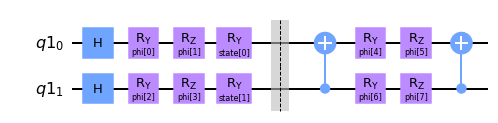

In [11]:
policy.circuit.draw('mpl')

In [12]:
policy.rot_param_vals

Parameter containing:
tensor([3.6398, 4.3774, 1.7679, 0.5780, 2.8442, 3.0178, 3.2316, 5.4090],
       requires_grad=True)

In [13]:
policy.enc_param_vals

Parameter containing:
tensor([0.2901, 0.7580], requires_grad=True)

In [14]:
inputs = torch.rand((10,2))

In [15]:
policy.forward(inputs)

array([[0.23216308],
       [0.19343   ],
       [0.22298987],
       [0.22990325],
       [0.21319031],
       [0.3329947 ],
       [0.24803457],
       [0.31917596],
       [0.33064734],
       [0.2369679 ]])

In [16]:
policy.forward(inputs)

array([[0.23216308],
       [0.19343   ],
       [0.22298987],
       [0.22990325],
       [0.21319031],
       [0.3329947 ],
       [0.24803457],
       [0.31917596],
       [0.33064734],
       [0.2369679 ]])

In [17]:
policy.forward(inputs)

array([[0.23216308],
       [0.19343   ],
       [0.22298987],
       [0.22990325],
       [0.21319031],
       [0.3329947 ],
       [0.24803457],
       [0.31917596],
       [0.33064734],
       [0.2369679 ]])

In [18]:
s = time.time()
a,b = policy.backward(inputs)
print(time.time()-s)

0.651566743850708


# Make Quantum Agent

In [19]:
class QuantumAgent():
    def __init__(self, input_state_dim, n_actions, n_layers=1, ansatz='base'):
        self.policy = PQC_with_DataReuploading(n_qubits=input_state_dim, n_layers=n_layers, 
                                               output_dim=n_actions, observables=None, ansatz=ansatz,
                                               activation='linear')
        self.n_layers = n_layers
        self.variational_optim = torch.optim.Adam([self.policy.rot_param_vals], lr=0.1)
        self.encoding_optim = torch.optim.Adam([self.policy.enc_param_vals], lr=0.1)
#         self.weight_optim = torch.optim.Adam([self.policy.w], lr=0.01)
        
        self.lr = 2
        
        self.optims = [self.variational_optim, self.encoding_optim]
        
    def get_actions(self, input_state):
        return self.policy.forward(input_state)
    
    def update_policy(self, states, returns, batch_size, action_probs):
        r_grad, e_grad = self.policy.backward(states)
        
#         p_actions = torch.tensor([action_probs[id_action_pairs[i][0], id_action_pairs[i][1]] for i in range(action_probs.shape[0])])
#         p_actions = p_actions.reshape(p_actions.shape[0], -1)
#         action_idxs = id_action_pairs[:,1]
        
        returns = returns.reshape(returns.shape[0], -1)

#         action_weights = agent.policy.w.detach().numpy()[id_action_pairs[:,1]]
#         action_weights = action_weights[:,np.newaxis]        
#         w = agent.policy.w.tile(len(states)).reshape(len(states),-1)
        
#         rot_grad = returns * ( r_grad * torch.tensor(action_weights) - torch.sum(p_actions * w) * r_grad)
#         input_scaled = self.policy.enc_param_vals * self.policy.get_input_tiled(states)        
#         enc_grad = returns * ( e_grad * torch.tensor(action_weights) - input_scaled * torch.sum(p_actions * w) * e_grad)
        
        rot_grad = -1*returns * r_grad * action_probs / torch.abs(action_probs)
        enc_grad = -1*returns * e_grad * action_probs / torch.abs(action_probs)

#         weight_grad = returns * ( w_grad * torch.tensor(action_weights) - torch.sum(p_actions * w) * w_grad)
        
        prev = self.policy.rot_param_vals.detach().numpy().copy()
        prev1 = self.policy.enc_param_vals.detach().numpy().copy()
#         prev2 = self.policy.w.detach().numpy().copy()
        
#         rot_update = (torch.mean(rot_grad.detach(), dim=0) / batch_size).type(torch.float32)
#         enc_update = (torch.mean(enc_grad, dim=0).detach() / batch_size).type(torch.float32)
#         w_update = (torch.mean(weight_grad, dim=0).detach() / batch_size).type(torch.float32)
        
        rot_update = torch.mean(rot_grad, dim=0) / batch_size
        enc_update = torch.mean(enc_grad, dim=0) / batch_size
#         w_update = torch.mean(weight_grad, dim=0) / batch_size
        
        
        with torch.no_grad():            
            self.policy.rot_param_vals += self.lr * rot_update
            self.policy.enc_param_vals += self.lr * enc_update
            
        print('Rot')
        print(self.policy.rot_param_vals.detach().numpy() / np.pi)
        print('Enc')
        print(self.policy.enc_param_vals.detach().numpy() / np.pi)
#             self.policy.w += 0.1 * w_update
    
#         self.policy.rot_param_vals.grad = -1*rot_update
#         self.policy.enc_param_vals.grad = -1*enc_update
#         self.policy.w.grad = -1*w_update
                
#         print(rot_update)
#         print(enc_update)
        
#         self.variational_optim.step()
#         self.encoding_optim.step()
#         self.weight_optim.step()

#         print(self.policy.rot_param_vals.detach() - prev)
#         print(rot_update)
        
#         print(self.policy.enc_param_vals.detach() - prev1)
#         print(enc_update)
#         print(self.policy.w.detach() - prev2)
#         print(w_update)
        
#         print('w', self.policy.w)
        
#         with torch.no_grad():
#             self.policy.rot_param_vals[self.policy.rot_param_vals > 2*np.pi] = 2*np.pi
#             self.policy.enc_param_vals[self.policy.enc_param_vals > 2*np.pi] = 2*np.pi
#             self.policy.rot_param_vals[self.policy.rot_param_vals < 0] = 0
#             self.policy.enc_param_vals[self.policy.enc_param_vals < 0] = 0
        
#         print(self.policy.rot_param_vals)

In [20]:
n_qubits = 2 # Dimension of the state vectors in CartPole
n_layers = 1
n_actions = 2 # Number of actions in CartPole
agent = QuantumAgent(input_state_dim = n_qubits, n_actions=n_actions, n_layers=n_layers, ansatz='omega2')

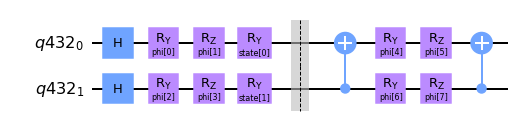

In [21]:
agent.policy.circuit.draw('mpl')

In [22]:
# with torch.no_grad():
#     agent.policy.rot_param_vals[0] = -np.pi/2 + np.pi/4 * torch.rand(1)
#     agent.policy.rot_param_vals[1] = np.pi + np.pi/2 * torch.rand(1)
#     agent.policy.rot_param_vals[2] = -np.pi/2 + np.pi/4 * torch.rand(1)
#     agent.policy.rot_param_vals[3] = np.pi + np.pi/2 * torch.rand(1)
    
#     agent.policy.rot_param_vals[4] = -np.pi/2 + np.pi/4 * torch.rand(1)
#     agent.policy.rot_param_vals[5] = np.pi + np.pi/2 * torch.rand(1)
#     agent.policy.rot_param_vals[6] = -np.pi/2 + np.pi/4 * torch.rand(1)
#     agent.policy.rot_param_vals[7] = np.pi + np.pi/2 * torch.rand(1)
    
#     agent.policy.enc_param_vals[0] = np.pi/2 + np.pi/4 * torch.rand(1)
#     agent.policy.enc_param_vals[1] = np.pi/2 + np.pi/4 * torch.rand(1)

In [23]:
# with torch.no_grad():
#     agent.policy.rot_param_vals[0] = -np.pi/2 
#     agent.policy.rot_param_vals[1] = np.pi 
#     agent.policy.rot_param_vals[2] = -np.pi/2 
#     agent.policy.rot_param_vals[3] = np.pi 
    
# #     agent.policy.rot_param_vals[4] = -np.pi/2 
# #     agent.policy.rot_param_vals[5] = np.pi
# #     agent.policy.rot_param_vals[6] = -np.pi/2 
# #     agent.policy.rot_param_vals[7] = np.pi
    
#     agent.policy.enc_param_vals[0] = np.pi/2 
#     agent.policy.enc_param_vals[1] = np.pi/2

In [24]:
agent.policy.rot_param_vals / np.pi

tensor([1.3108, 1.5643, 0.4194, 1.9177, 0.3734, 1.8641, 1.7464, 0.7519],
       grad_fn=<DivBackward0>)

In [25]:
agent.policy.enc_param_vals / np.pi

tensor([0.3117, 0.2417], grad_fn=<DivBackward0>)

# Run Episodes and Update Policy

In [26]:
def gather_episodes(state_bounds, n_actions, agent, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    if env_name == 'Curling':
        envs = [Curling(reward_type='each_end_counts') for _ in range(n_episodes)]
#         envs = [Curling(reward_type='winner_takes_it_all') for _ in range(n_episodes)]
    else:
        envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]
    

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        states = torch.from_numpy(np.array(normalized_states))
#         print(states)
        action_probs = agent.get_actions(states)
#         print(action_probs)
        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        
        for i, action_prob in zip(unfinished_ids, action_probs):
            if action_prob > 0: # 회로 출력(측정 결과)
                action = 0 # 수비적
            else:
                action = 1 # 공격적
            states[i], reward, done[i], _ = envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)  
            trajectories[i]['action probs'].append(action_prob)  
#             print('action', action)
#             print('reward', reward)
#             print('')
#             print('state', states[i])
            
    return trajectories

def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [27]:
env_name = "Curling"
# env_name = "Curling"
if env_name == "CartPole-v1":
    state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
elif env_name == 'Curling':
    state_bounds = np.array([0, 1])
gamma = 1
batch_size = 5
n_episodes = 2000

In [28]:
# Start training the agent
episode_reward_history = []
reward_history = []
# Monitoring reward
monitor_reward_history = []
for batch in tqdm(range(n_episodes // batch_size)):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, agent, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
    actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
    action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = torch.from_numpy(np.array(returns))
    print('len_game', len(states))
#     action_probs = [ep['action_probs'] for ep in episodes]

#     id_action_pairs = torch.from_numpy(np.array([[i, a] for i, a in enumerate(actions)]))

    # Update model parameters.
    agent.update_policy(states, returns, batch_size, action_probs)
    
#     if batch % 25 == 0 and batch != 0:
#         agent.lr *= 0.5
#     print(states)
#     print(actions)
#     print(rewards)
    print(action_probs)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-batch_size:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)
    
    if batch % 2 == 1:
        # Gather episodes
        episodes_monitor = gather_episodes(state_bounds, n_actions, agent, 50, env_name)

        # Group states, actions and returns in numpy arrays
        states_monitor = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes_monitor]))
        actions_monitor = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes_monitor]))
        action_probs_monitor = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes_monitor]))
        rewards_monitor = [ep['rewards'] for ep in episodes_monitor]
        # Store collected rewards
        temp_hist = []
        for ep_rwds in rewards_monitor:
            temp_hist.append(np.sum(ep_rwds))
        avg_rewards_monitor = np.mean(temp_hist)
        monitor_reward_history.append(avg_rewards_monitor)
        
        print('Monitored episode', 50,
              'Average Monitored rewards: ', avg_rewards_monitor)
        
    if avg_rewards >= 500.0:
        break

  0%|          | 0/400 [00:00<?, ?it/s]

len_game 50
Rot
[1.3168867  1.5527661  0.42008352 1.9177859  0.3588515  1.8641111
 1.7464267  0.7518858 ]
Enc
[0.32953033 0.24234247]
tensor([[-0.0683],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [-0.0683],
        [-0.7631],
        [-0.6914],
        [-0.7631],
        [-0.6914],
        [-0.0683],
        [-0.7631],
        [-0.7631],
        [-0.7631],
        [-0.6914],
        [-0.1753],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.6152],
        [ 0.5675],
        [ 0.5675],
        [-0.1753],
        [-0.7631],
        [-0.7631],
        [-0.7631],
        [-0.7631],
        [-0.7631],
        [-0.7631],
        [-0.7631],
        [-0.6914],
        [-0.7631],
        [-0.0683],
        [-0.0683],
        [ 0.6152],
        [ 0.5675],
        [-0.1753],
        [-0

Rot
[1.356012   1.5236237  0.44515115 1.9167544  0.32176137 1.8641111
 1.7464267  0.7518858 ]
Enc
[0.38758102 0.26778302]
tensor([[-0.3521],
        [ 0.6361],
        [-0.3521],
        [-0.8480],
        [-0.8480],
        [-0.7960],
        [-0.7960],
        [-0.2217],
        [-0.8480],
        [-0.8480],
        [-0.3521],
        [-0.8480],
        [-0.8480],
        [-0.8480],
        [-0.8480],
        [-0.7960],
        [-0.7960],
        [-0.2217],
        [-0.8480],
        [-0.8480],
        [-0.3521],
        [-0.8480],
        [-0.8480],
        [-0.8480],
        [-0.8480],
        [-0.8480],
        [-0.8480],
        [-0.8480],
        [-0.8480],
        [-0.7960],
        [-0.2217],
        [-0.8480],
        [-0.7960],
        [-0.8480],
        [-0.7960],
        [ 0.6361],
        [ 0.6361],
        [ 0.6361],
        [ 0.6361],
        [ 0.6361],
        [-0.2217],
        [-0.2217],
        [ 0.6361],
        [ 0.6361],
        [ 0.6361],
        [ 0.6361],
    

Monitored episode 50 Average Monitored rewards:  22.22
len_game 50
Rot
[1.366939   1.4888437  0.45193803 1.9167377  0.2515055  1.8641111
 1.7464267  0.7518858 ]
Enc
[0.46403113 0.27432892]
tensor([[-0.4800],
        [-0.7089],
        [-0.7089],
        [-0.6936],
        [-0.6936],
        [-0.7089],
        [-0.7089],
        [-0.6936],
        [-0.6936],
        [-0.3453],
        [-0.3453],
        [-0.3453],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.5878],
        [ 0.5878],
        [ 0.5878],
        [-0.4800],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [-0.4800],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [ 0.6065],
        [-0.3453],
        [-0.7089],
        [-0.3

Rot
[1.3662975  1.4777334  0.4591516  1.9164916  0.21530175 1.8641111
 1.7464267  0.7518858 ]
Enc
[0.48906013 0.28160718]
tensor([[-0.4009],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5590],
        [-0.5590],
        [-0.5574],
        [-0.5590],
        [-0.5590],
        [-0.4009],
        [-0.5294],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5590],
        [-0.5590],
        [-0.5590],
        [-0.5294],
        [ 0.5420],
        [ 0.5420],
        [ 0.5420],
        [ 0.5420],
        [ 0.5420],
        [ 0.5420],
        [ 0.5349],
        [ 0.5349],
        [ 0.5349],
        [-0.4009],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.5590],
        [-0.5574],
        [-0.5574],
        [-0.5574],
        [-0.4009],
        [ 0.5420],
        [ 0.5420],
        [ 0.5420],
        [ 0.5349],
    

Monitored episode 50 Average Monitored rewards:  38.28
len_game 51
Rot
[1.3581835  1.4568204  0.48576486 1.9158666  0.1475002  1.8641111
 1.7464267  0.7518858 ]
Enc
[0.5357134  0.30896267]
tensor([[-0.4342],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [-0.5199],
        [-0.4196],
        [-0.4276],
        [-0.4276],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4668],
        [-0.5199],
        [-0.5199],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4668],
        [ 0.4668],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [-0.4342],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [ 0.4671],
        [-0.4342],
        [-0.4

Rot
[1.3482547  1.4551227  0.51241904 1.9156934  0.12632264 1.8641111
 1.7464267  0.7518858 ]
Enc
[0.5410842  0.33659878]
tensor([[-0.4445],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [-0.4445],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [-0.4445],
        [-0.4445],
        [ 0.3988],
        [ 0.3975],
        [-0.3961],
        [-0.3279],
        [-0.3279],
        [-0.3207],
        [ 0.3988],
        [ 0.3988],
        [-0.3961],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [ 0.3988],
        [-0.3961],
        [-0.3961],
        [-0.3279],
        [-0.3207],
        [ 0.3988],
        [ 0.3988],
    

Monitored episode 50 Average Monitored rewards:  31.96
len_game 50
Rot
[1.3377357  1.4472989  0.53859264 1.9160408  0.10707131 1.8641111
 1.7464267  0.7518858 ]
Enc
[0.55720055 0.36368343]
tensor([[-0.2837],
        [-0.1830],
        [-0.1830],
        [-0.1830],
        [-0.1322],
        [-0.1322],
        [-0.4577],
        [-0.1830],
        [-0.1830],
        [-0.1322],
        [-0.4577],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.2945],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [-0.4577],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [-0.2837],
        [-0.1830],
        [-0.1322],
        [-0.1830],
        [-0.1322],
        [-0.4577],
        [ 0.3122],
        [ 0.3122],
        [ 0.3122],
        [ 0.2945],
        [-0.4577],
        [-0.4577],
        [-0.4

Rot
[1.3133776  1.4048337  0.5990667  1.9192168  0.00729295 1.8641111
 1.7464267  0.7518858 ]
Enc
[0.6316352  0.42628127]
tensor([[-0.4388],
        [-0.0206],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [-0.0727],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [ 0.1725],
        [-0.4388],
        [-0.0206],
        [ 0.1725],
        [-0.4388],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
        [-0.0727],
        [-0.0727],
        [-0.0206],
        [-0.0206],
        [ 0.1725],
        [ 0.1725],
        [ 0.1725],
        [-0.4388],
        [-0.0206],
        [-0.0206],
        [-0.4388],
        [-0.0206],
        [-0.4388],
        [ 0.1475],
        [ 0.1475],
        [ 0.1475],
    

Monitored episode 50 Average Monitored rewards:  54.52
len_game 50
Rot
[ 1.2883492   1.3556355   0.67323655  1.9268632  -0.01236125  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.7026585  0.50251794]
tensor([[ 3.4657e-01],
        [ 3.4657e-01],
        [-2.0261e-01],
        [-2.0261e-01],
        [-2.0261e-01],
        [-2.0261e-01],
        [ 4.1126e-01],
        [ 4.1126e-01],
        [ 4.1126e-01],
        [ 4.1126e-01],
        [ 3.4657e-01],
        [-2.0261e-01],
        [-3.3809e-01],
        [-2.6725e-04],
        [-2.6725e-04],
        [-2.1869e-01],
        [-2.1869e-01],
        [-2.6725e-04],
        [-2.6725e-04],
        [-2.1869e-01],
        [-3.3809e-01],
        [-2.6725e-04],
        [-2.6725e-04],
        [-2.6725e-04],
        [-2.1869e-01],
        [-2.6725e-04],
        [-2.6725e-04],
        [-2.1869e-01],
        [-2.6725e-04],
        [-2.6725e-04],
        [-3.3809e-01],
        [-2.6725e-04],
        [-2.1869e-01],
        [-2.1869e-01],
        [-2.0261e-01]

Rot
[ 1.2512294   1.2880272   0.7405245   1.937631   -0.04850473  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.7885369 0.5714025]
tensor([[ 0.6037],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [ 0.4167],
        [ 0.4167],
        [ 0.4167],
        [ 0.4167],
        [ 0.6037],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [-0.6262],
        [ 0.4167],
        [-0.3070],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.6037],
        [-0.6262],
        [ 0.4167],
        [-0.3070],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [-0.3070],
        [ 0.0583],
        [ 0.0583],
        [ 0.0583],
        [-0.3078],
        [-0.3078]

Monitored episode 50 Average Monitored rewards:  40.28
len_game 50
Rot
[ 1.2302399   1.2296907   0.7886505   1.9499102  -0.05152392  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8429179 0.6207714]
tensor([[-0.2584],
        [-0.8275],
        [-0.8275],
        [-0.8275],
        [ 0.3999],
        [ 0.3999],
        [-0.2584],
        [-0.8275],
        [ 0.3999],
        [-0.2584],
        [-0.2584],
        [ 0.0488],
        [ 0.0488],
        [ 0.0488],
        [ 0.0488],
        [ 0.0488],
        [ 0.0488],
        [ 0.0488],
        [ 0.0488],
        [ 0.0488],
        [-0.2584],
        [-0.8275],
        [-0.8275],
        [-0.8275],
        [-0.8275],
        [-0.8275],
        [-0.8275],
        [ 0.3999],
        [ 0.3999],
        [ 0.3999],
        [ 0.7083],
        [-0.8275],
        [-0.8275],
        [-0.8275],
        [ 0.3999],
        [ 0.3999],
        [ 0.3999],
        [-0.8275],
        [-0.8275],
        [ 0.3999],
        [ 0.7083],
        [ 0.0488],
       

Rot
[ 1.2589784  1.1793056  0.8329542  1.965666  -0.0543646  1.8641111
  1.7464267  0.7518858]
Enc
[0.84647775 0.6662123 ]
tensor([[ 0.7935],
        [-0.0383],
        [-0.0383],
        [ 0.7935],
        [ 0.7935],
        [-0.0383],
        [-0.0383],
        [-0.0383],
        [-0.0383],
        [-0.0383],
        [ 0.7935],
        [-0.0383],
        [-0.0383],
        [-0.9033],
        [-0.9033],
        [ 0.3335],
        [ 0.3335],
        [ 0.3335],
        [-0.1608],
        [-0.0383],
        [ 0.7935],
        [ 0.7935],
        [-0.9033],
        [-0.1608],
        [-0.0383],
        [-0.0383],
        [-0.5535],
        [-0.5535],
        [-0.0383],
        [-0.0383],
        [-0.0383],
        [-0.1608],
        [-0.9033],
        [-0.0383],
        [-0.0383],
        [-0.0383],
        [-0.5535],
        [-0.0383],
        [-0.5535],
        [-0.5535],
        [-0.5535],
        [-0.1608],
        [-0.9033],
        [ 0.3335],
        [-0.9033],
        [ 0.3335],
   

Monitored episode 50 Average Monitored rewards:  49.38
len_game 50
Rot
[ 1.2709079   1.1450131   0.8563902   1.9765888  -0.06088636  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8541735 0.690108 ]
tensor([[-0.2117],
        [-0.9433],
        [-0.0093],
        [-0.0093],
        [ 0.8524],
        [-0.9433],
        [-0.9433],
        [-0.9433],
        [-0.9433],
        [-0.9433],
        [-0.2117],
        [-0.2117],
        [-0.9433],
        [-0.9433],
        [ 0.3917],
        [ 0.3917],
        [-0.2117],
        [-0.0093],
        [-0.9433],
        [-0.0093],
        [-0.2117],
        [-0.9433],
        [-0.9433],
        [-0.9433],
        [-0.9433],
        [-0.9433],
        [ 0.3917],
        [ 0.3917],
        [ 0.3917],
        [ 0.3917],
        [ 0.8524],
        [-0.9433],
        [-0.2117],
        [-0.2117],
        [-0.0093],
        [-0.5964],
        [-0.9433],
        [-0.9433],
        [-0.9433],
        [-0.9433],
        [-0.2117],
        [-0.0093],
       

Rot
[ 1.2439512   1.1129936   0.85447323  1.9828385  -0.08463355  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.89261276 0.68838555]
tensor([[-0.2076],
        [ 0.0174],
        [ 0.0174],
        [ 0.0174],
        [-0.6032],
        [-0.6032],
        [-0.6032],
        [ 0.8343],
        [-0.9457],
        [-0.9457],
        [-0.2076],
        [ 0.0174],
        [-0.6032],
        [-0.6032],
        [-0.9457],
        [ 0.3681],
        [-0.2076],
        [ 0.0174],
        [ 0.0174],
        [ 0.0174],
        [-0.2076],
        [ 0.0174],
        [ 0.0174],
        [ 0.0174],
        [ 0.0174],
        [ 0.0174],
        [ 0.0174],
        [ 0.0174],
        [-0.6032],
        [-0.6032],
        [ 0.8343],
        [-0.9457],
        [-0.9457],
        [-0.9457],
        [ 0.3681],
        [ 0.3681],
        [ 0.3681],
        [ 0.3681],
        [-0.2076],
        [-0.2076],
        [-0.2076],
        [-0.2076],
        [ 0.0174],
        [ 0.0174],
        [-0.6032],
        [ 0.834

Monitored episode 50 Average Monitored rewards:  29.58
len_game 51
Rot
[ 1.2548686   1.0889924   0.85278565  1.988293   -0.09254964  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.89017946 0.6868299 ]
tensor([[ 0.8408],
        [-0.9564],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [-0.2299],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [-0.6067],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.8408],
        [-0.9564],
        [-0.9564],
        [ 0.3845],
        [ 0.3845],
        [ 0.3845],
        [ 0.3845],
        [ 0.3845],
        [-0.2299],
        [ 0.0430],
        [-0.2299],
        [-0.9564],
        [-0.9564],
        [ 0.3845],
        [ 0.3845],
        [-0.2299],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.0430],
        [ 0.8408],
        [-0.9564],
     

Rot
[ 1.2591491   1.0751961   0.8639071   1.991517   -0.08777327  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.89008665 0.6979948 ]
tensor([[ 0.8562],
        [ 0.8562],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [ 0.3629],
        [ 0.3629],
        [ 0.3629],
        [-0.2019],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [-0.9595],
        [ 0.8562],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [-0.6418],
        [-0.6418],
        [-0.2019],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.0147],
        [ 0.8562],
        [-0.9595],
        [-0.2019],
        [ 0.0147],
        [ 0.0147],
        [ 0.014

Monitored episode 50 Average Monitored rewards:  26.64
len_game 50
Rot
[ 1.2656081   1.0661849   0.8861137   1.9936137  -0.07916282  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8860346 0.7202163]
tensor([[ 0.8489],
        [-0.9425],
        [-0.9425],
        [-0.9425],
        [-0.9425],
        [-0.9425],
        [-0.9425],
        [ 0.3744],
        [ 0.3744],
        [ 0.3744],
        [ 0.8489],
        [ 0.8489],
        [-0.9425],
        [-0.9425],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [-0.2092],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.8489],
        [-0.9425],
        [-0.9425],
        [-0.9425],
        [-0.9425],
        [-0.9425],
        [ 0.3744],
        [ 0.3744],
        [ 0.3744],
        [ 0.3744],
        [ 0.8489],
        [-0.9425],
       

Rot
[ 1.2585977   1.0525975   0.85863733  1.9953429  -0.1012819   1.8641111
  1.7464267   0.7518858 ]
Enc
[0.89552146 0.6927568 ]
tensor([[-0.0943],
        [-0.0794],
        [ 0.8961],
        [-0.9768],
        [-0.9768],
        [-0.9768],
        [ 0.2595],
        [ 0.2595],
        [ 0.2595],
        [ 0.2595],
        [ 0.8961],
        [-0.9768],
        [-0.0943],
        [-0.0943],
        [-0.0943],
        [-0.9768],
        [-0.9768],
        [-0.9768],
        [-0.9768],
        [ 0.2595],
        [-0.0943],
        [-0.0794],
        [ 0.8961],
        [-0.9768],
        [-0.9768],
        [ 0.2595],
        [-0.0943],
        [-0.9768],
        [-0.9768],
        [-0.9768],
        [-0.0943],
        [-0.9768],
        [-0.9768],
        [-0.9768],
        [ 0.2595],
        [ 0.2595],
        [ 0.2595],
        [ 0.2595],
        [ 0.2595],
        [ 0.2595],
        [ 0.8961],
        [-0.9768],
        [-0.0943],
        [-0.0794],
        [-0.7336],
        [-0.079

Monitored episode 50 Average Monitored rewards:  50.86
len_game 50
Rot
[ 1.2790632   1.0446104   0.8771707   1.9968349  -0.06614404  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8766097 0.7112976]
tensor([[ 0.8908],
        [-0.9752],
        [-0.1118],
        [-0.9752],
        [ 0.2745],
        [-0.1118],
        [-0.0613],
        [-0.0613],
        [-0.0613],
        [-0.0613],
        [ 0.8908],
        [ 0.8908],
        [-0.9752],
        [-0.9752],
        [ 0.2745],
        [ 0.2745],
        [-0.1118],
        [-0.1118],
        [-0.0613],
        [-0.0613],
        [-0.1118],
        [-0.0613],
        [-0.0613],
        [-0.0613],
        [-0.0613],
        [-0.0613],
        [-0.7236],
        [-0.0613],
        [-0.0613],
        [-0.0613],
        [ 0.8908],
        [ 0.8908],
        [-0.9752],
        [-0.9752],
        [-0.9752],
        [-0.9752],
        [-0.9752],
        [-0.9752],
        [-0.9752],
        [-0.9752],
        [-0.1118],
        [-0.0613],
       

Rot
[ 1.2763357   1.0371923   0.8818968   1.9977708  -0.06309168  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8803903 0.7160269]
tensor([[ 0.8695],
        [ 0.8695],
        [-0.9613],
        [-0.1370],
        [-0.9613],
        [ 0.2921],
        [-0.1370],
        [-0.0307],
        [-0.0307],
        [-0.0307],
        [-0.1370],
        [-0.0307],
        [-0.6982],
        [-0.0307],
        [-0.6982],
        [-0.0307],
        [-0.0307],
        [-0.0307],
        [-0.0307],
        [-0.6982],
        [-0.1370],
        [-0.1370],
        [-0.9613],
        [-0.9613],
        [ 0.2921],
        [ 0.2921],
        [ 0.2921],
        [-0.0307],
        [-0.0307],
        [-0.6982],
        [-0.1370],
        [-0.1370],
        [-0.1370],
        [-0.0307],
        [ 0.8695],
        [-0.9613],
        [-0.1370],
        [-0.0307],
        [-0.0307],
        [-0.6982],
        [ 0.8695],
        [-0.9613],
        [-0.9613],
        [ 0.2921],
        [ 0.2921],
        [-0.1370]

Monitored episode 50 Average Monitored rewards:  26.98
len_game 50
Rot
[ 1.2692456   1.0301552   0.8646252   1.9984294  -0.09052319  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.88830894 0.69875735]
tensor([[ 0.8501],
        [-0.9565],
        [-0.9565],
        [-0.9565],
        [-0.9565],
        [-0.9565],
        [ 0.4191],
        [ 0.4191],
        [ 0.4191],
        [ 0.4191],
        [ 0.8501],
        [-0.9565],
        [-0.9565],
        [-0.2658],
        [-0.9565],
        [-0.9565],
        [ 0.4191],
        [ 0.0710],
        [ 0.0710],
        [ 0.0710],
        [-0.2658],
        [-0.9565],
        [-0.9565],
        [-0.9565],
        [ 0.4191],
        [-0.2658],
        [ 0.0710],
        [ 0.0710],
        [ 0.0710],
        [ 0.0710],
        [ 0.8501],
        [-0.9565],
        [-0.9565],
        [ 0.0710],
        [ 0.0710],
        [ 0.0710],
        [ 0.0710],
        [ 0.0710],
        [ 0.0710],
        [ 0.0710],
        [ 0.8501],
        [-0.9565],
     

Rot
[ 1.2659475   1.0253807   0.87034243  1.9989007  -0.07676712  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8921026  0.70447534]
tensor([[-0.2675],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [-0.5973],
        [ 0.0822],
        [ 0.0822],
        [ 0.8292],
        [-0.9413],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [-0.5973],
        [-0.9413],
        [-0.9413],
        [-0.9413],
        [-0.9413],
        [ 0.8292],
        [-0.9413],
        [-0.9413],
        [ 0.4142],
        [ 0.0822],
        [ 0.0822],
        [-0.5973],
        [-0.5973],
        [-0.9413],
        [-0.9413],
        [ 0.8292],
        [-0.9413],
        [-0.2675],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [ 0.0822],
        [-0.2675],
        [-0.2675],
        [-0.9413],
        [-0.9413],
        [-0.9413],
        [-0.941

Monitored episode 50 Average Monitored rewards:  53.96
len_game 52
Rot
[ 1.2707962   1.020413    0.8572051   1.9992473  -0.07791446  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8876661 0.6913386]
tensor([[ 0.8862],
        [-0.9812],
        [-0.9812],
        [-0.9812],
        [ 0.3460],
        [-0.1824],
        [-0.1824],
        [-0.9812],
        [-0.9812],
        [ 0.3460],
        [-0.1824],
        [-0.1824],
        [-0.9812],
        [-0.9812],
        [-0.9812],
        [-0.9812],
        [-0.9812],
        [-0.9812],
        [ 0.3460],
        [ 0.3460],
        [ 0.3460],
        [-0.1824],
        [-0.9812],
        [-0.9812],
        [ 0.3460],
        [ 0.3460],
        [-0.1824],
        [-0.9812],
        [-0.9812],
        [-0.9812],
        [-0.9812],
        [-0.1824],
        [-0.0026],
        [-0.6871],
        [-0.0026],
        [-0.6871],
        [-0.0026],
        [-0.0026],
        [-0.6871],
        [-0.9812],
        [-0.9812],
        [ 0.8862],
       

Rot
[ 1.2786065   1.0174385   0.8699325   1.9994696  -0.06304412  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.88007504 0.704066  ]
tensor([[-0.1528],
        [-0.9821],
        [-0.9821],
        [-0.9821],
        [-0.9821],
        [-0.9821],
        [-0.9821],
        [-0.9821],
        [ 0.3149],
        [-0.9821],
        [-0.1528],
        [-0.0252],
        [-0.0252],
        [-0.7068],
        [-0.0252],
        [ 0.8905],
        [ 0.8905],
        [-0.9821],
        [-0.0252],
        [-0.9821],
        [-0.1528],
        [-0.1528],
        [-0.0252],
        [-0.0252],
        [-0.7068],
        [-0.0252],
        [-0.0252],
        [-0.0252],
        [-0.7068],
        [-0.0252],
        [ 0.8905],
        [ 0.8905],
        [-0.9821],
        [-0.9821],
        [ 0.3149],
        [-0.1528],
        [-0.0252],
        [-0.7068],
        [ 0.8905],
        [-0.0252],
        [ 0.8905],
        [ 0.8905],
        [ 0.8905],
        [ 0.8905],
        [-0.9821],
        [-0.982

Monitored episode 50 Average Monitored rewards:  53.46
len_game 50
Rot
[ 1.2934682   1.0143791   0.8686263   1.9996449  -0.06032137  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.86540544 0.70276   ]
tensor([[-0.1606],
        [-0.0347],
        [-0.0347],
        [-0.7155],
        [-0.7155],
        [-0.0347],
        [-0.0347],
        [-0.0347],
        [-0.0347],
        [-0.0347],
        [-0.1606],
        [-0.1606],
        [-0.9905],
        [-0.1606],
        [-0.0347],
        [-0.9905],
        [-0.0347],
        [-0.0347],
        [-0.7155],
        [-0.0347],
        [-0.1606],
        [-0.9905],
        [-0.0347],
        [-0.9905],
        [-0.9905],
        [-0.9905],
        [-0.9905],
        [ 0.3362],
        [ 0.3362],
        [ 0.3362],
        [ 0.9088],
        [ 0.9088],
        [-0.9905],
        [-0.1606],
        [-0.0347],
        [-0.7155],
        [ 0.9088],
        [-0.9905],
        [-0.9905],
        [-0.9905],
        [-0.1606],
        [-0.0347],
     

Rot
[ 1.2803793   1.0120351   0.87437534  1.9997429  -0.05243552  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.878602 0.708509]
tensor([[ 0.8925],
        [-0.9849],
        [-0.1807],
        [-0.0072],
        [-0.6932],
        [-0.9849],
        [-0.9849],
        [ 0.3469],
        [ 0.3469],
        [-0.9849],
        [-0.1807],
        [-0.0072],
        [-0.0072],
        [-0.6932],
        [-0.6932],
        [-0.0072],
        [-0.0072],
        [-0.0072],
        [-0.6932],
        [-0.6932],
        [ 0.8925],
        [-0.9849],
        [-0.0072],
        [-0.9849],
        [-0.9849],
        [-0.9849],
        [-0.9849],
        [-0.9849],
        [-0.9849],
        [-0.9849],
        [-0.1807],
        [-0.0072],
        [-0.0072],
        [-0.0072],
        [-0.0072],
        [-0.6932],
        [-0.6932],
        [-0.0072],
        [-0.6932],
        [-0.0072],
        [-0.1807],
        [-0.0072],
        [-0.0072],
        [-0.0072],
        [-0.6932],
        [-0.6932],


Monitored episode 50 Average Monitored rewards:  38.08
len_game 52
Rot
[ 1.2532908  1.0094526  0.8424135  1.9998069 -0.1050811  1.8641111
  1.7464267  0.7518858]
Enc
[0.90577585 0.6765472 ]
tensor([[ 0.8846],
        [-0.9828],
        [-0.9828],
        [-0.9828],
        [-0.9828],
        [ 0.3480],
        [ 0.3480],
        [-0.1873],
        [ 0.0049],
        [ 0.0049],
        [-0.1873],
        [-0.9828],
        [-0.1873],
        [-0.9828],
        [ 0.3480],
        [-0.1873],
        [ 0.0049],
        [ 0.0049],
        [ 0.0049],
        [ 0.0049],
        [ 0.8846],
        [-0.9828],
        [-0.9828],
        [ 0.3480],
        [ 0.3480],
        [ 0.3480],
        [ 0.3480],
        [-0.1873],
        [-0.9828],
        [-0.9828],
        [ 0.8846],
        [ 0.8846],
        [-0.9828],
        [-0.9828],
        [ 0.3480],
        [ 0.3480],
        [-0.1873],
        [-0.1873],
        [-0.9828],
        [-0.9828],
        [ 0.8846],
        [-0.9828],
        [-0.

Rot
[ 1.2507204   1.0081835   0.855955    1.9998513  -0.09095054  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.9083834  0.69008875]
tensor([[ 8.6035e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [ 3.0464e-01],
        [ 3.0464e-01],
        [ 8.6035e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [ 3.0464e-01],
        [ 3.0464e-01],
        [ 3.0464e-01],
        [ 3.0464e-01],
        [ 3.0464e-01],
        [-1.5874e-01],
        [ 8.6035e-01],
        [-9.6114e-01],
        [-9.6114e-01],
        [ 3.0464e-01],
        [ 3.0464e-01],
        [ 3.0464e-01],
        [ 3.0464e-01],
        [-9.5748e-04],
        [-9.6114e-01],
        [ 3.0464e-01],
        [-1.5874e-01],
        [-1.5874e-01],
        [-9.6114e-01],
        [ 3.0464e-01],
        [-1.5874e-01],
        [-9.6114e-01],
        [-9.6114e-0

Monitored episode 50 Average Monitored rewards:  48.54
len_game 51
Rot
[ 1.2895404   1.0071905   0.8857884   1.9998993  -0.05142059  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.86960024 0.7199221 ]
tensor([[-0.1377],
        [-0.9817],
        [-0.9817],
        [-0.0473],
        [-0.0473],
        [-0.0473],
        [-0.7223],
        [-0.0473],
        [-0.7223],
        [-0.0473],
        [-0.1377],
        [-0.0473],
        [-0.7223],
        [-0.0473],
        [ 0.9003],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [ 0.3079],
        [ 0.3079],
        [-0.1377],
        [-0.0473],
        [-0.0473],
        [-0.0473],
        [-0.0473],
        [-0.7223],
        [-0.7223],
        [ 0.9003],
        [-0.9817],
        [-0.1377],
        [-0.1377],
        [ 0.9003],
        [-0.9817],
        [-0.0473],
        [-0.0473],
        [-0.7223],
        [-0.7223],
        [-0.9817],
        [-0.9817],
        [ 0.3079],
        [ 0.3079],
        [ 0.9003],
     

Rot
[ 1.2801841   1.005849    0.86832947  1.9999266  -0.07130256  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8789855 0.7024632]
tensor([[ 0.8644],
        [ 0.8644],
        [-0.9728],
        [-0.2719],
        [-0.9728],
        [-0.2719],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.8644],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [ 0.4244],
        [ 0.4244],
        [ 0.4244],
        [-0.2719],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.0762],
        [ 0.8644],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [-0.9728],
        [ 0.8644],
        [-0.9728],
        [-0.2719],
        [-0.2719],
        [ 0.0762],
        [ 0.0762]

Monitored episode 50 Average Monitored rewards:  47.46
len_game 52
Rot
[ 1.2677804   1.0048599   0.8596073   1.9999458  -0.07681282  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8914068 0.6937411]
tensor([[-0.1668],
        [-0.9802],
        [-0.9802],
        [-0.9802],
        [ 0.3238],
        [ 0.3238],
        [ 0.3238],
        [ 0.3238],
        [-0.1668],
        [-0.0072],
        [-0.1668],
        [-0.1668],
        [-0.0072],
        [-0.6946],
        [-0.0072],
        [-0.0072],
        [-0.0072],
        [-0.0072],
        [-0.6946],
        [-0.6946],
        [ 0.8825],
        [-0.9802],
        [-0.1668],
        [-0.9802],
        [-0.9802],
        [ 0.3238],
        [ 0.3238],
        [ 0.3238],
        [-0.1668],
        [-0.9802],
        [-0.1668],
        [-0.1668],
        [-0.1668],
        [-0.0072],
        [-0.0072],
        [-0.0072],
        [-0.0072],
        [-0.6946],
        [-0.0072],
        [-0.0072],
        [-0.6946],
        [-0.6946],
       

Rot
[ 1.2680202   1.0040759   0.8645823   1.9999615  -0.07290374  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8911802 0.6987161]
tensor([[-0.1590],
        [-0.9757],
        [-0.9757],
        [ 0.3150],
        [ 0.3150],
        [ 0.3150],
        [-0.1590],
        [-0.9757],
        [-0.1590],
        [-0.0126],
        [ 0.8796],
        [-0.9757],
        [-0.1590],
        [-0.0126],
        [-0.9757],
        [-0.9757],
        [-0.9757],
        [-0.9757],
        [-0.9757],
        [-0.9757],
        [-0.1590],
        [-0.9757],
        [ 0.3150],
        [-0.1590],
        [-0.0126],
        [-0.0126],
        [-0.0126],
        [-0.0126],
        [-0.6971],
        [-0.6971],
        [ 0.8796],
        [ 0.8796],
        [-0.0126],
        [-0.0126],
        [ 0.8796],
        [-0.9757],
        [-0.9757],
        [ 0.3150],
        [ 0.3150],
        [ 0.3150],
        [-0.1590],
        [-0.1590],
        [-0.1590],
        [-0.9757],
        [-0.9757],
        [ 0.3150]

Monitored episode 50 Average Monitored rewards:  44.58
len_game 50
Rot
[ 1.25101     1.003469    0.8694209   1.9999694  -0.10178274  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.90819716 0.7035547 ]
tensor([[ 0.8429],
        [-0.9419],
        [-0.9419],
        [-0.9419],
        [-0.9419],
        [-0.9419],
        [ 0.3388],
        [ 0.3388],
        [ 0.3388],
        [-0.1878],
        [ 0.8429],
        [-0.9419],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [-0.1878],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [ 0.0175],
        [-0.6570],
        [ 0.8429],
        [-0.9419],
        [-0.9419],
        [ 0.8429],
        [-0.9419],
        [-0.9419],
        [-0.9419],
        [-0.9419],
        [-0.9419],
        [ 0.3388],
        [-0.9419],
        [-0.9419],
        [-0.9419],
        [-0.1878],
        [-0.9419],
     

Rot
[ 1.2792931   1.0029598   0.88299924  1.9999793  -0.06078246  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8799211  0.71713305]
tensor([[-0.1189],
        [-0.0541],
        [-0.0541],
        [ 0.8920],
        [-0.9751],
        [-0.9751],
        [-0.9751],
        [ 0.2810],
        [-0.1189],
        [-0.9751],
        [ 0.8920],
        [ 0.8920],
        [ 0.8920],
        [-0.9751],
        [-0.9751],
        [-0.9751],
        [ 0.2810],
        [ 0.2810],
        [-0.0541],
        [-0.0541],
        [ 0.8920],
        [-0.9751],
        [-0.1189],
        [-0.0541],
        [-0.7263],
        [-0.9751],
        [-0.0541],
        [ 0.8920],
        [ 0.8920],
        [-0.9751],
        [-0.1189],
        [-0.0541],
        [-0.0541],
        [-0.0541],
        [-0.0541],
        [-0.0541],
        [-0.0541],
        [-0.7263],
        [-0.7263],
        [-0.7263],
        [-0.1189],
        [-0.1189],
        [-0.0541],
        [-0.0541],
        [-0.7263],
        [-0.726

Monitored episode 50 Average Monitored rewards:  36.0
len_game 50
Rot
[ 1.2669115   1.0025531   0.8804556   1.999984   -0.06664553  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.89230645 0.7145894 ]
tensor([[ 0.8364],
        [-0.9386],
        [-0.9386],
        [-0.2400],
        [ 0.0543],
        [ 0.0543],
        [-0.6219],
        [-0.6219],
        [-0.6219],
        [ 0.0543],
        [-0.2400],
        [ 0.0543],
        [ 0.0543],
        [ 0.0543],
        [ 0.0543],
        [ 0.0543],
        [ 0.0543],
        [ 0.0543],
        [ 0.0543],
        [-0.6219],
        [ 0.8364],
        [-0.9386],
        [-0.9386],
        [-0.9386],
        [ 0.3935],
        [ 0.3935],
        [ 0.3935],
        [ 0.3935],
        [ 0.3935],
        [ 0.3935],
        [ 0.8364],
        [-0.9386],
        [-0.9386],
        [-0.9386],
        [-0.9386],
        [-0.9386],
        [ 0.3935],
        [-0.9386],
        [-0.9386],
        [ 0.3935],
        [-0.2400],
        [-0.9386],
      

Rot
[ 1.264302    1.0022432   0.88261896  1.9999874  -0.076169    1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8949183  0.71675277]
tensor([[-0.1563],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [ 0.8749],
        [-0.9597],
        [-0.9597],
        [-0.0256],
        [-0.0256],
        [-0.0256],
        [-0.0256],
        [-0.0256],
        [-0.6956],
        [-0.6956],
        [ 0.8749],
        [-0.0256],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [ 0.3213],
        [ 0.3213],
        [ 0.3213],
        [ 0.3213],
        [ 0.3213],
        [-0.1563],
        [-0.0256],
        [-0.0256],
        [-0.0256],
        [-0.0256],
        [-0.0256],
        [-0.0256],
        [-0.0256],
        [-0.6956],
        [-0.6956],
        [ 0.8749],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [-0.9597],
        [-0.959

Monitored episode 50 Average Monitored rewards:  65.66
len_game 50
Rot
[ 1.2669184   1.0019397   0.88033485  1.9999905  -0.07784137  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.89230436 0.71446866]
tensor([[ 0.8682],
        [-0.9575],
        [-0.9575],
        [-0.9575],
        [-0.9575],
        [-0.9575],
        [-0.9575],
        [-0.9575],
        [-0.9575],
        [-0.9575],
        [ 0.8682],
        [-0.9575],
        [-0.0254],
        [-0.9575],
        [-0.1444],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.6973],
        [-0.0254],
        [-0.1444],
        [-0.0254],
        [-0.0254],
        [-0.6973],
        [-0.6973],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [ 0.8682],
        [ 0.8682],
        [-0.9575],
        [-0.9575],
        [-0.9575],
        [ 0.3006],
        [ 0.3006],
        [ 0.3006],
        [ 0.3006],
        [ 0.3006],
        [-0.1444],
        [-0.9575],
     

Rot
[ 1.2676464   1.001592    0.8649464   1.9999932  -0.08612395  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.89157856 0.6990802 ]
tensor([[ 0.8565],
        [ 0.0482],
        [ 0.0482],
        [ 0.0482],
        [ 0.0482],
        [-0.6380],
        [ 0.8565],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.2346],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.2346],
        [ 0.0482],
        [-0.6380],
        [ 0.0482],
        [ 0.0482],
        [ 0.0482],
        [ 0.0482],
        [ 0.0482],
        [ 0.0482],
        [ 0.0482],
        [-0.2346],
        [-0.2346],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [ 0.3897],
        [ 0.3897],
        [ 0.3897],
        [ 0.3897],
        [ 0.3897],
        [ 0.8565],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.9609],
        [-0.960

Monitored episode 50 Average Monitored rewards:  42.62
len_game 50
Rot
[ 1.2716428   1.0013185   0.8586833   1.9999951  -0.09475575  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.88758373 0.6928171 ]
tensor([[ 0.8759],
        [ 0.8759],
        [-0.9750],
        [-0.2398],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [-0.2398],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.8759],
        [-0.9750],
        [-0.9750],
        [-0.2398],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.0429],
        [ 0.8759],
        [-0.9750],
        [-0.9750],
        [-0.9750],
        [-0.9750],
        [-0.9750],
        [-0.9750],
        [-0.9750],
        [ 0.4012],
        [ 0.4012],
        [ 0.8759],
        [-0.9750],
     

Rot
[ 1.2725477   1.0011281   0.86224365  1.9999967  -0.10295194  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8866799  0.69637746]
tensor([[-0.2048],
        [-0.9787],
        [-0.9787],
        [-0.2048],
        [-0.9787],
        [-0.9787],
        [-0.9787],
        [-0.9787],
        [-0.9787],
        [ 0.3788],
        [-0.2048],
        [-0.9787],
        [-0.2048],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [-0.6819],
        [-0.6819],
        [-0.6819],
        [ 0.8945],
        [ 0.8945],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.8945],
        [-0.9787],
        [ 0.3788],
        [-0.2048],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [ 0.0014],
        [-0.2048],
        [ 0.0014],
        [ 0.0014],
        [-0.6819],
        [ 0.0014],
        [ 0.001

Monitored episode 50 Average Monitored rewards:  32.5
len_game 50
Rot
[ 1.252113    1.0009731   0.86991197  1.9999971  -0.09106125  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.9071151 0.7040458]
tensor([[-0.1769],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [-0.6768],
        [-0.1769],
        [-0.1769],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.0043],
        [ 0.8637],
        [-0.9618],
        [-0.9618],
        [-0.9618],
        [ 0.3313],
        [ 0.3313],
        [ 0.3313],
        [ 0.3313],
        [ 0.3313],
        [-0.1769],
        [-0.1769],
        [ 0.0043],
        [ 0.0043],
        [-0.6768],
        [-0.9618],
        [-0.1769],
        [-0.9618],
        [-0.9618],
        [ 0.3313],
        [ 0.3313],
        [-0.1769],
        [-0.9618],
        

Rot
[ 1.2628635   1.0008442   0.86961365  1.9999979  -0.07165808  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8963649  0.70374745]
tensor([[-0.1496],
        [-0.1496],
        [-0.0140],
        [-0.0140],
        [-0.0140],
        [-0.0140],
        [-0.0140],
        [-0.6937],
        [-0.6937],
        [-0.6937],
        [ 0.8665],
        [ 0.8665],
        [-0.9623],
        [-0.9623],
        [-0.9623],
        [-0.9623],
        [-0.9623],
        [-0.9623],
        [-0.9623],
        [-0.9623],
        [ 0.8665],
        [ 0.8665],
        [-0.9623],
        [-0.0140],
        [-0.0140],
        [-0.0140],
        [ 0.8665],
        [-0.0140],
        [-0.9623],
        [-0.9623],
        [ 0.8665],
        [-0.9623],
        [-0.9623],
        [ 0.2998],
        [-0.1496],
        [-0.9623],
        [-0.9623],
        [ 0.2998],
        [ 0.2998],
        [-0.1496],
        [-0.1496],
        [ 0.8665],
        [ 0.8665],
        [ 0.8665],
        [-0.9623],
        [-0.014

Monitored episode 50 Average Monitored rewards:  48.9
len_game 50
Rot
[ 1.2764298   1.0007303   0.8804165   1.9999983  -0.06446283  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8827991 0.7145503]
tensor([[ 0.8773],
        [-0.9680],
        [-0.9680],
        [ 0.2996],
        [ 0.2996],
        [-0.1429],
        [-0.1429],
        [-0.0272],
        [-0.0272],
        [-0.0272],
        [-0.1429],
        [-0.0272],
        [-0.7042],
        [-0.9680],
        [-0.9680],
        [ 0.2996],
        [-0.9680],
        [-0.9680],
        [-0.9680],
        [-0.9680],
        [-0.1429],
        [-0.9680],
        [-0.1429],
        [-0.0272],
        [-0.0272],
        [-0.0272],
        [-0.0272],
        [-0.7042],
        [-0.0272],
        [-0.0272],
        [ 0.8773],
        [-0.9680],
        [-0.1429],
        [-0.1429],
        [-0.1429],
        [-0.9680],
        [-0.9680],
        [-0.9680],
        [ 0.2996],
        [ 0.2996],
        [-0.1429],
        [-0.0272],
        

Rot
[ 1.2698047   1.0005955   0.8654144   1.9999987  -0.10530207  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8894247 0.6995482]
tensor([[ 0.8797],
        [ 0.8797],
        [ 0.8797],
        [ 0.8797],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [-0.2129],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [-0.2129],
        [-0.2129],
        [-0.9694],
        [-0.9694],
        [ 0.3810],
        [ 0.3810],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [-0.2129],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150],
        [-0.2129],
        [-0.9694],
        [ 0.3810],
        [ 0.0150],
        [ 0.0150],
        [ 0.0150]

Monitored episode 50 Average Monitored rewards:  55.3
len_game 50
Rot
[ 1.2788231   1.0005188   0.8811503   1.9999989  -0.06245934  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.88040656 0.7152841 ]
tensor([[-0.1169],
        [-0.0550],
        [-0.0550],
        [-0.0550],
        [-0.0550],
        [-0.0550],
        [-0.0550],
        [-0.7298],
        [-0.7298],
        [-0.7298],
        [-0.1169],
        [-0.9799],
        [-0.9799],
        [-0.9799],
        [-0.1169],
        [-0.0550],
        [-0.7298],
        [-0.0550],
        [-0.0550],
        [-0.0550],
        [ 0.8957],
        [-0.9799],
        [-0.9799],
        [-0.9799],
        [ 0.2782],
        [ 0.2782],
        [ 0.2782],
        [-0.1169],
        [-0.0550],
        [-0.0550],
        [ 0.8957],
        [-0.9799],
        [-0.9799],
        [-0.9799],
        [-0.9799],
        [-0.9799],
        [ 0.2782],
        [ 0.2782],
        [ 0.2782],
        [ 0.2782],
        [ 0.8957],
        [-0.9799],
      

Rot
[ 1.2579821   1.0004287   0.8696402   1.999999   -0.07994641  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.9012477 0.7037739]
tensor([[ 0.8329],
        [ 0.8329],
        [-0.9450],
        [-0.9450],
        [-0.9450],
        [-0.9450],
        [-0.9450],
        [ 0.3840],
        [ 0.3840],
        [ 0.3840],
        [ 0.8329],
        [-0.9450],
        [-0.2384],
        [ 0.0641],
        [-0.6205],
        [-0.9450],
        [-0.2384],
        [-0.9450],
        [-0.9450],
        [-0.9450],
        [ 0.8329],
        [-0.9450],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [-0.2384],
        [ 0.0641],
        [-0.6205],
        [-0.6205],
        [ 0.8329],
        [-0.9450],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [-0.2384],
        [-0.9450],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641],
        [ 0.0641]

Monitored episode 50 Average Monitored rewards:  42.16
len_game 53
Rot
[ 1.2689943  1.0003614  0.8654287  1.9999993 -0.0792356  1.8641111
  1.7464267  0.7518858]
Enc
[0.8902356  0.69956243]
tensor([[ 0.8481],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [ 0.8481],
        [ 0.8481],
        [-0.9620],
        [-0.9620],
        [-0.9620],
        [-0.9620],
        [ 0.4026],
        [ 0.4026],
        [ 0.4026],
        [ 0.4026],
        [-0.2548],
        [-0.2548],
        [-0.2548],
        [-0.9620],
        [-0.9620],
        [-0.9620],
        [ 0.4026],
        [ 0.4026],
        [ 0.4026],
        [-0.2548],
        [-0.2548],
        [-0.2548],
        [ 0.8481],
        [-0.9620],
        [-0.9620],
        [ 0.4026],
        [-0.2548],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [ 0.0725],
        [-0.6196],
        [-0.

Rot
[ 1.2729579   1.0003046   0.870289    1.9999993  -0.07350883  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.88627213 0.70442283]
tensor([[ 0.8439],
        [-0.9518],
        [ 0.4202],
        [-0.2699],
        [-0.2699],
        [-0.2699],
        [-0.9518],
        [-0.9518],
        [-0.9518],
        [-0.9518],
        [ 0.8439],
        [ 0.0783],
        [ 0.0783],
        [-0.6072],
        [-0.6072],
        [-0.9518],
        [-0.2699],
        [-0.9518],
        [-0.2699],
        [-0.9518],
        [ 0.8439],
        [-0.9518],
        [-0.9518],
        [-0.9518],
        [-0.9518],
        [-0.9518],
        [ 0.4202],
        [ 0.4202],
        [ 0.4202],
        [ 0.4202],
        [-0.2699],
        [-0.9518],
        [-0.2699],
        [ 0.0783],
        [-0.6072],
        [ 0.0783],
        [ 0.0783],
        [ 0.0783],
        [ 0.0783],
        [ 0.0783],
        [-0.2699],
        [ 0.0783],
        [ 0.0783],
        [ 0.0783],
        [ 0.0783],
        [ 0.078

Monitored episode 50 Average Monitored rewards:  40.54
len_game 52
Rot
[ 1.2628052   1.0002606   0.8663318   1.9999993  -0.08721735  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8964249 0.7004656]
tensor([[-0.2245],
        [ 0.0399],
        [ 0.8526],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [ 0.3803],
        [ 0.3803],
        [ 0.8526],
        [-0.9543],
        [ 0.0399],
        [ 0.8526],
        [-0.9543],
        [-0.9543],
        [ 0.3803],
        [ 0.3803],
        [ 0.3803],
        [-0.2245],
        [-0.2245],
        [ 0.0399],
        [ 0.0399],
        [ 0.0399],
        [ 0.0399],
        [ 0.0399],
        [ 0.0399],
        [ 0.0399],
        [ 0.0399],
        [ 0.0399],
        [ 0.8526],
        [-0.9543],
        [-0.2245],
        [-0.9543],
        [-0.9543],
        [ 0.3803],
        [ 0.3803],
        [ 0.3803],
        [ 0.3803],
        [ 0.3803],
        [-0.2245],
        [-0.2245],
       

Rot
[ 1.2559861   1.0002154   0.86332214  1.9999993  -0.0949724   1.8641111
  1.7464267   0.7518858 ]
Enc
[0.9032441  0.69745594]
tensor([[ 0.8713],
        [ 0.8713],
        [ 0.0038],
        [ 0.0038],
        [-0.6779],
        [-0.9670],
        [-0.9670],
        [ 0.3431],
        [ 0.3431],
        [ 0.3431],
        [-0.1837],
        [ 0.8713],
        [-0.9670],
        [-0.9670],
        [-0.9670],
        [-0.9670],
        [ 0.3431],
        [ 0.3431],
        [ 0.3431],
        [ 0.3431],
        [ 0.3431],
        [ 0.8713],
        [ 0.8713],
        [-0.9670],
        [-0.9670],
        [ 0.3431],
        [-0.9670],
        [ 0.3431],
        [ 0.3431],
        [ 0.3431],
        [ 0.3431],
        [-0.1837],
        [ 0.8713],
        [-0.9670],
        [-0.9670],
        [ 0.3431],
        [-0.9670],
        [-0.9670],
        [ 0.3431],
        [-0.9670],
        [-0.1837],
        [ 0.0038],
        [ 0.8713],
        [ 0.0038],
        [ 0.0038],
        [ 0.003

Monitored episode 50 Average Monitored rewards:  49.28
len_game 51
Rot
[ 1.2698306   1.0001876   0.8738937   1.9999993  -0.08261239  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8893995 0.7080275]
tensor([[-0.2069],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.8698],
        [-0.9668],
        [-0.2069],
        [-0.9668],
        [-0.9668],
        [ 0.3678],
        [ 0.3678],
        [ 0.3678],
        [ 0.3678],
        [ 0.3678],
        [-0.2069],
        [-0.2069],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [-0.2069],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [ 0.0199],
        [-0.2069],
       

Rot
[ 1.270024    1.0001556   0.86710835  1.9999994  -0.08888541  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8892061  0.70124215]
tensor([[-0.1508],
        [-0.9817],
        [-0.1508],
        [-0.0446],
        [-0.0446],
        [-0.7191],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [ 0.3280],
        [ 0.9049],
        [-0.9817],
        [-0.9817],
        [-0.1508],
        [-0.0446],
        [-0.7191],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [ 0.3280],
        [ 0.9049],
        [ 0.9049],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [ 0.3280],
        [ 0.3280],
        [-0.1508],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [ 0.3280],
        [-0.9817],
        [ 0.3280],
        [ 0.3280],
        [ 0.3280],
        [-0.1508],
        [-0.1508],
        [-0.1508],
        [-0.9817],
        [-0.9817],
        [-0.9817],
        [-0.981

Monitored episode 50 Average Monitored rewards:  28.9
len_game 50
Rot
[ 1.2747908   1.0001334   0.8681768   1.9999994  -0.07746768  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8844395 0.7023106]
tensor([[ 0.8474],
        [-0.9591],
        [-0.9591],
        [-0.9591],
        [-0.9591],
        [-0.2718],
        [-0.2718],
        [ 0.0824],
        [ 0.0824],
        [ 0.0824],
        [ 0.8474],
        [ 0.8474],
        [ 0.8474],
        [ 0.8474],
        [-0.9591],
        [-0.9591],
        [ 0.4202],
        [-0.2718],
        [ 0.0824],
        [ 0.0824],
        [-0.2718],
        [ 0.0824],
        [ 0.0824],
        [ 0.0824],
        [ 0.0824],
        [ 0.0824],
        [ 0.0824],
        [ 0.0824],
        [ 0.0824],
        [ 0.0824],
        [-0.2718],
        [-0.9591],
        [-0.9591],
        [-0.9591],
        [-0.9591],
        [ 0.4202],
        [ 0.4202],
        [ 0.4202],
        [ 0.4202],
        [ 0.4202],
        [-0.2718],
        [ 0.0824],
        

Rot
[ 1.2639942   1.0001082   0.86325294  1.9999994  -0.08334476  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.8952361  0.69738674]
tensor([[-0.2118],
        [ 0.0263],
        [-0.6618],
        [ 0.8718],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [ 0.3708],
        [-0.9726],
        [-0.9726],
        [ 0.8718],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [ 0.3708],
        [ 0.3708],
        [-0.2118],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [ 0.3708],
        [ 0.3708],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [ 0.3708],
        [-0.2118],
        [-0.9726],
        [ 0.0263],
        [ 0.0263],
        [ 0.0263],
        [ 0.0263],
        [ 0.0263],
        [ 0.0263],
        [ 0.0263],
        [ 0.0263],
        [-0.2118],
        [-0.9726],
        [-0.9726],
        [-0.9726],
        [ 0.3708],
        [ 0.370

Monitored episode 50 Average Monitored rewards:  33.86
len_game 50
Rot
[ 1.250557    1.0000862   0.8529994   1.9999994  -0.11262225  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.9086733 0.6871332]
tensor([[-0.1898],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [-0.1898],
        [-0.1898],
        [-0.9642],
        [-0.9642],
        [ 0.3417],
        [-0.1898],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.8612],
        [ 0.8612],
        [-0.9642],
        [-0.9642],
        [-0.9642],
        [-0.1898],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [ 0.0181],
        [-0.1898],
        [-0.1898],
        [-0.9642],
        [-0.1898],
        [ 0.0181],
        [-0.6679],
        [ 0.8612],
        [ 0.8612],
        [-0.9642],
        [ 0.0181],
        [ 0.8612],
        [-0.9642],
       

Rot
[ 1.277828    1.0000758   0.88137716  1.9999994  -0.06060607  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.88140225 0.71551096]
tensor([[ 0.8472],
        [ 0.8472],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [ 0.4171],
        [ 0.4171],
        [ 0.4171],
        [-0.2655],
        [ 0.0739],
        [ 0.0739],
        [ 0.0739],
        [ 0.0739],
        [ 0.0739],
        [-0.6122],
        [-0.6122],
        [-0.6122],
        [-0.6122],
        [ 0.8472],
        [-0.2655],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [ 0.4171],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [ 0.4171],
        [-0.2655],
        [-0.9543],
        [-0.9543],
        [-0.9543],
        [ 0.4171],
        [ 0.4171],
        [ 0.4171],
        [-0.2655],
        [-0.9543],
        [ 0.4171],
        [-0.2655],
        [-0.2655],
        [ 0.0739],
        [ 0.0739],
        [ 0.073

Monitored episode 50 Average Monitored rewards:  48.94
len_game 50
Rot
[ 1.2679276   1.0000627   0.863026    1.9999994  -0.07746083  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.89130265 0.6971598 ]
tensor([[-0.1268],
        [-0.0400],
        [-0.0400],
        [-0.7202],
        [-0.0400],
        [-0.0400],
        [-0.7202],
        [-0.7202],
        [-0.0400],
        [-0.0400],
        [ 0.8888],
        [-0.9790],
        [-0.1268],
        [-0.9790],
        [-0.9790],
        [-0.9790],
        [ 0.2825],
        [ 0.2825],
        [-0.1268],
        [-0.1268],
        [ 0.8888],
        [ 0.8888],
        [-0.9790],
        [-0.1268],
        [-0.0400],
        [ 0.8888],
        [-0.9790],
        [ 0.2825],
        [-0.1268],
        [-0.9790],
        [-0.1268],
        [-0.0400],
        [-0.0400],
        [ 0.8888],
        [-0.9790],
        [ 0.2825],
        [-0.1268],
        [-0.9790],
        [-0.9790],
        [-0.9790],
        [-0.1268],
        [-0.0400],
     

Rot
[ 1.279325    1.0000522   0.85120666  1.9999994  -0.10596696  1.8641111
  1.7464267   0.7518858 ]
Enc
[0.87990516 0.68534046]
tensor([[ 0.9014],
        [-0.9825],
        [-0.9825],
        [-0.9825],
        [-0.9825],
        [-0.9825],
        [-0.9825],
        [-0.9825],
        [-0.9825],
        [-0.9825],
        [ 0.9014],
        [-0.9825],
        [-0.9825],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.9014],
        [-0.9825],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [-0.6698],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.9014],
        [-0.9825],
        [-0.2330],
        [ 0.0185],
        [-0.6698],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [-0.2330],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.0185],
        [ 0.018

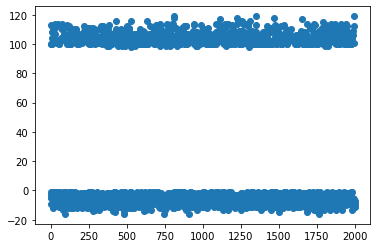

In [29]:
plt.scatter(range(len(episode_reward_history)), episode_reward_history)

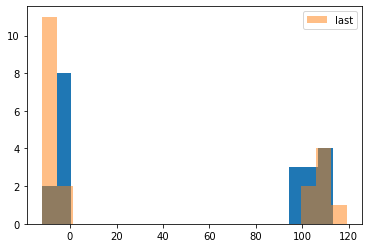

In [30]:
plt.hist(episode_reward_history[:20], bins=20)
plt.hist(episode_reward_history[-20:], bins=20, label='last',alpha = 0.5)
plt.legend()
# plt.savefig('hist.png')

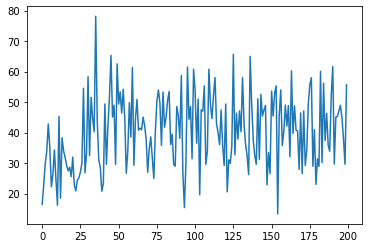

In [31]:
plt.plot(monitor_reward_history)
# plt.savefig('rewardmonitor.png')

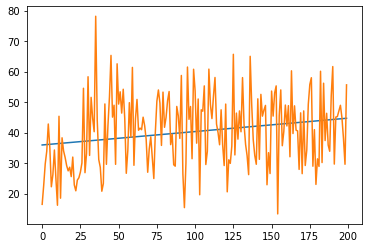

In [32]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import pickle as pkl

def linear(x, y_intercept, slope):
    return y_intercept + (x * slope)

def third_poly(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3
data_len = len(monitor_reward_history)
x = np.arange(data_len)
popt, pcov = curve_fit(linear, x, monitor_reward_history)
plt.plot(linear(x, popt[0], popt[1]))
plt.plot(monitor_reward_history)
